# Fluid Model (approach 2)

This program takes the forces found for the Electrostatic and the Surface Tension solvers, and creates a Vector-Valued function for external forces.

Furtherly, it iterates the Navier Stokes equations, in order to find the velocity that the polymer would have, in order to iterate the Level Set Equation, using the velocity obtained.

In [ ]:
#Setup FeniCs
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [ ]:
pip install meshio

<ipython-input-5-a7dbd47c246f>:31: RuntimeWarning: overflow encountered in exp
  values[0] = 2/(1+ np.exp((((x[0] - 250)**20 + (x[1] - 50.85)**20)**(1/20) - self.R)/self.delta)) - 1


(48.0, 50.0)

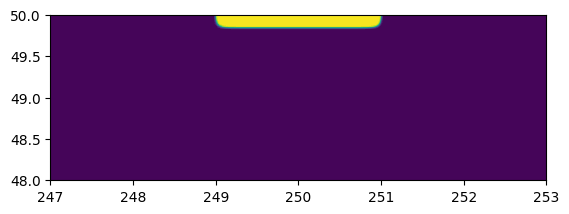

In [5]:
from dolfin import *
from math import tanh
from math import exp
import numpy as np
import matplotlib.pyplot as plt# Create mesh
"""nx, ny = 250, 250
mesh = UnitSquareMesh(nx, ny)"""

"""msh = meshio.read("reznik4.xml")
mesh = Mesh("reznik4.xml")"""


mesh = RectangleMesh(Point(245,45), Point(255,50), 600,300)  #Define mesh

# Define function space
W = FunctionSpace(mesh, 'CG', 2)

# Define parameters
R = 1 # Radius of the circle
delta = 0.005 # Width of the interface

# Define initial condition class
class InitialConditions(UserExpression):
    def __init__(self, R, delta, **kwargs):
        self.R = R
        self.delta = delta
        super().__init__(**kwargs)

    def eval(self, values, x):
        #Define the initial condition for the fluid upon leaving the needle
        values[0] = 2/(1+ np.exp((((x[0] - 250)**20 + (x[1] - 50.85)**20)**(1/20) - self.R)/self.delta)) - 1

    def value_shape(self):
        return ()

initial_condition = InitialConditions(R, delta, degree=1)
phi_n = interpolate(initial_condition, W) #Initialize the model

plot(phi_n)
plt.xlim(247, 253)
plt.ylim(48, 50)

In [8]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def find_zero_level_set(mesh, phi):
    # Extract mesh coordinates and phi values
    mesh_coordinates = mesh.coordinates()
    phi_values = phi.compute_vertex_values()

    # Find nodes where phi is approximately zero (excluding the boundary).
    #Note that value has to be tracked so that the boundary is correctly found. Note that value must be similar to cero, however  there is great dependence over the number of nodes
    zero_level_set_nodes = [
        i for i, value in enumerate(phi_values) if (
            (value) < 0.5 and mesh_coordinates[i][1] > 42 and mesh_coordinates[i][1] <= 50 and value > 0
        )
    ]

    # Extract coordinates of zero level set nodes
    zero_level_set_coordinates = mesh_coordinates[zero_level_set_nodes]
    return zero_level_set_coordinates, zero_level_set_nodes  # Return nodes as well

# Call the function to find zero level set nodes
zero_level_set_coordinates, zero_level_set_nodes = find_zero_level_set(mesh, phi_n)

# Create scatter plot (Visualization of data)
fig = make_subplots(rows=1, cols=1, subplot_titles=["Zero Level Set Nodes"])
scatter = go.Scatter(
    x=zero_level_set_coordinates[:, 0],
    y=zero_level_set_coordinates[:, 1],
    mode='markers',
    marker=dict(color='red', size=8),
    text=[f'phi = {phi_n.compute_vertex_values()[node]:.4f}' for node in zero_level_set_nodes] #Show value of nodes, great for assigning the values
)

fig.add_trace(scatter)

# Update layout
fig.update_layout(
    title_text="Zero Level Set Nodes",
    xaxis_title="x",
    yaxis_title="y",
    showlegend=False
)

# Show the interactive plot
fig.show()

In [9]:
import math

#This block is in charge of sorting the nodes, in order to apply the forces on each node correctly
def angle_with_reference(point, reference_point):
      x, y = point[0] - reference_point[0], point[1] - reference_point[1]
      return math.atan2(y, x)

def sort_counterclockwise(points):
      # Find the centroid as the reference point
      reference_point = [250,50]

      # Sort points based on the angle with the reference point
      sorted_points = sorted(points, key=lambda point: angle_with_reference(point, reference_point))

      return sorted_points

boundary_coords = sort_counterclockwise(zero_level_set_coordinates)

In [10]:
#This block creates artificial, forces, for explaining purposes. Swittch to the values obtained with the electrostatic and ST solvers

points = zero_level_set_coordinates
line1 = np.linspace(-0.02, -1000, num= round(len(points)/2))
line2 = np.flip(line1)

line = [j for i in [line1 , [-1000], line2] for j in i]

line1x = np.linspace(-4, 0, num= round(len(points)/2))
line2x = np.linspace(0, 4, num= round(len(points)/2))

linex = [j for i in [line1x , [0], line2x] for j in i]

Fs = []
for i in range(0, len(line)):
  Fs.append([linex[i], line[i]])

In [11]:
from matplotlib.cbook import normalize_kwargs
#SelfImplemented Navier-Stokes Problem with Chorin Proj IPCS
#For reference, check the Navier Stokes implementation on the folder

#Define Taylor-Hood elements (For now, they work best for Navier-Stokes problems)
V = VectorFunctionSpace(mesh, 'P', 2) #Function space that solves for velocity
Q = FunctionSpace(mesh, 'P', 1) #Function space that solves for pressure

#Define Two sets of Test/Trial functions, as we are working with two unknowns.
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

V_plot = FunctionSpace(mesh, 'P', 2)
mu_function = Function(V_plot)
rho_function = Function(V_plot)


def up_boundary(x, on_boundary):
  tol = 1E-8
  return(on_boundary and near(x[1], 50) and between(x[0], (249,251)))

def down_boundary(x, on_boundary):
  tol = 1E-8
  return(on_boundary and abs(x[1])< tol)

def left_boundary(x, on_boundary):
  return(on_boundary and near(x[0], 245))

def right_boundary(x, on_boundary):
  return(on_boundary and near(x[0], 255))

def pressureCond(x, on_boundary):
  tol = 1E-8
  return(on_boundary and near(x[1], 45))


def left(x, on_boundary):
  if(on_boundary):
    if(near(x[0],0) or near(x[0],1)):
      return False
    else:
      return True

def upno(x, on_boundary):
  if(on_boundary):
    if((between(x[0],(245,249)) or between(x[0],(251,255))) and near(x[1],50) and on_boundary):
      return True
    else:
      return False

DBup = DirichletBC(V, Constant((0,-0.001)) , up_boundary)  #Note that constants must be two dimentional , there is a flow donwnwards
#DBdown = DirichletBC(V, Constant((0,0)) , down_boundary)
DBleft = DirichletBC(V, Constant((0,0)) , left_boundary)
DBright = DirichletBC(V, Constant((0,0)) , right_boundary)
DBcond = DirichletBC(Q, Constant(0) , pressureCond)
#DBelect = DirichletBC(V, Constant((0,0)) , left)
DBupno = DirichletBC(V, Constant((0,0)) , upno)  #Note that constants must be two dimentional

bcs = [DBleft, DBright, DBupno, DBup] #Add all Dirichlet BC into a list
bcs2 = [DBcond]
#bcs = [DBup, DBelect]
# Define functions for solutions at previous and current time steps
u_n = Function(V) #Es importante definirlas puesto que voy a iterar en el tiempo
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

#Formulation of the variational form of NavierStokes

#Parameter Creation

T = 1      # final time
num_steps = 1000  # number of time steps
dt = T / num_steps # time step size

ucond = 1

mu_2 = Constant(0.1) #Visc of the air
mu_1 = Constant(212) #Visc of the polymer
rho_1 = Constant(100) #Den of the polymer
rho_2 = Constant(0.1) #Den ofthe air

#Definition for the viscosity and density regarding the node, in order to have different values for the Polymer-gas interface
mu = Expression('mu_inside + 0.5 * (mu_outside - mu_inside) * (1.0 + tanh(phi_n))', degree=1, mu_inside=mu_2, mu_outside=mu_1, phi_n=phi_n)
rho = Expression('rho_inside + 0.5 * (rho_outside - rho_inside) * (1.0 + tanh(2*phi_n))', degree=1, rho_inside=rho_2, rho_outside=rho_1, phi_n=phi_n)


# Define expressions used in variational forms
U  = 0.5*(u_n + u)
n  = FacetNormal(mesh) #Esto me crea un vector normal a la superficie planteada
k  = Constant(dt)


# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

#Variational form due to Chorin's Projection.


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_f4c31f6e8b0e7ddceb14ce599aa08d063c1bdf82

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00411797 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0237522 seconds.

INFO:FFC:Compiler stage 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00658488 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0718534 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:---------------------------

In [12]:
#Create external Forces File

#Taking the forces found, create a vector valued function, in order to apply it to the variational form of the Navier Stokes equations
f = Function(V)
x = V.tabulate_dof_coordinates()

for point, value in zip(points, Fs):
    # Calculate the Euclidean distance between each node and the target point
    distances = np.linalg.norm(x - np.array(point), axis=1)

    # Find the index of the closest node
    index = np.argmin(distances)

    # Assign the value to the node
    f.vector().vec().setValuesLocal([index], [value[0]])
    f.vector().vec().setValuesLocal([index+1], [value[1]])


f.vector().vec().assemble()

In [ ]:
F1 = rho*dot((u - u_n) / k, v)*dx + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx  + inner(sigma(U, p_n), epsilon(v))*dx + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds  - dot(f, v)*dx

a1 = lhs(F1)
L1 = rhs(F1)

#Pressure Correction
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

#Velocity correction due to pressure
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

In [ ]:
[bc.apply(A1) for bc in bcs] #Apply boundary conditions to A
[bc.apply(A2) for bc in bcs2]
[bc.apply(A3) for bc in bcs]

t = 0
i = 0
norms = []
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcs]
    solve(A1, u_.vector(), b1,  'bicgstab', 'hypre_amg') #Preconditioned settings for linear solving methods that accelerate process

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcs2]
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    [bc.apply(b3) for bc in bcs]
    solve(A3, u_.vector(), b3, 'cg', 'sor')

    #If we wish to plot magnitude of velocity, we must plot norm (Only works on 2D)
    x1,y1=u_.split(deepcopy=True)
    norm1 = (x1*x1 + y1*y1)**(0.5)

    x2, y2 = u_n.split(deepcopy = True)
    norm2 = (x2*x2 + y2*y2)**(0.5)

    diff_norm = sqrt(assemble(inner(u_ - u_n, u_ - u_n) * dx))

    if (i%1 == 0):
      name = "NS/output" + str(i) + ".jpg"
      a  = plot(u_ , title = "Trial simulation")
      plt.xlim(247, 253)
      plt.ylim(47,50)
      plt.colorbar(a)
      plt.savefig(name) #save as jpg
      plt.clf()
      file = File("vel.pvd")
      file << u_

    norms.append(diff_norm)
    print(diff_norm)
    if (diff_norm < 0.00001):
      print("Convergence")
      break

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
    i = i+1

In [15]:
savecon = phi_n.copy() #Copy the values for the concentration, in order to furtherly manipulate ir

In [ ]:
# Define parameters to iterate the level set equation
uyo = u_  #The velocity used to iterate the level set equation is the velocity found with the Navier Stokes equations

phi = TrialFunction(W)
#phi_n = interpolate(initial_condition, W)  # Initial condition
w = TestFunction(W)

T = 10            # final time
num_steps = 500  # number of time steps
dt = T / num_steps # time step size

t = 0
i = 0
j = 0

num_cells = mesh.num_cells()
area_mesh = 1 #Calculate the area of the mesh, for the SUPG
h = area_mesh/num_cells

while t < T:
    if (i%1 == 0):

      name = "Move/output" + j*"a" + ".jpg"
      a = plot(phi_n, dt, title="Level Set Equation")
      plt.xlim(247,253)
      plt.ylim(48,50)
      plt.colorbar(a)
      plt.savefig(name)
      plt.clf()
      j = j +1

    phi = TrialFunction(W)

    norm_u = 1

    #Variational form for the level set equation with SUPG
    s = h/(2*norm_u) * dot(grad(w), uyo)

    a = dot(phi, w)*dx - dt/2 *dot(phi, dot(grad(w) , uyo))*dx  + dot(phi, s)*dx + dt/2 *dot(s, dot(grad(phi), uyo))*dx
    L = dot(phi_n , w)*dx + dt/2 *dot(phi_n , dot(grad(w) , uyo))*dx + dot(phi_n, s)*dx - dt/2 *dot(s, dot(grad(phi_n), uyo))*dx


    # Create a function to store the solution
    phi = Function(W)


    def boundaryatt (x, on_boundary):
        return (on_boundary and between(x[0], (249,251)) and near(x[1], 50))


    bcs = [DirichletBC(W, Constant(1.0), boundaryatt)]

    A, b = assemble_system(a, L, bcs)

    solve(A, phi.vector(), b)

    if (i == 20):
      break

    #Adjust values greater than 1, to 1. This won't be needed once the reinitialization process is conducted
    phi_values = phi.vector().get_local()
    phi_values[phi_values < -1.0] = -1.0
    phi.vector().set_local(phi_values)
    phi.vector().apply("insert")

    phi_values = phi.vector().get_local()
    phi_values[phi_values > 0.75] = 1.0
    phi.vector().set_local(phi_values)
    phi.vector().apply("insert")

    t += dt
    phi_n.assign(phi)  # Update the solution for the next time step

    file = File("electro.pvd") #Save as Paraview Visualization file
    file << phi
    i +=1

In [17]:
#Create .geo() file, used in order to re-iterate the electrostatic solver

with open('NSlev.txt', 'w') as file:
    # Write content to the file
    for i in range(0, len(points)-1):
      file.write("//+ \n")
      file.write("Point("+str(i+1) +") = {" + str(points[i][0]) + "," + str(points[i][1]) + ",0,1}; \n")

    file.write("//+//+ \n")

    for i in range(1, len(points)-1):
      file.write("//+ \n")
      file.write("Line(" + str(i) + ") = {" + str(i) +", " + str(i+1)+"}; \n")
    file.write("Line(" + str(len(points)-1) + ") = { 1 ," + str(len(points)-1) + "}; \n" )